In [1]:
import gc
import os
import string

import matplotlib.pyplot as plt
from jupyterthemes import jtplot

import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
from torch import optim
from torchinfo import summary

from collections import namedtuple
import PyPDF3

In [2]:
jtplot.style("gruvboxd")

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
device

device(type='cuda')

In [5]:
DATA_DIR = os.getcwd().replace('notebooks', 'data')

with open(os.path.join(DATA_DIR, 'anna.txt'), 'r') as file:
    text = file.read()

In [6]:
text[:120]

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverything was in confusion i'

In [7]:
unique_chars = list(set(text))

In [8]:
len(unique_chars)

83

In [9]:
unique_chars

['v',
 ':',
 '*',
 'z',
 '%',
 'm',
 '!',
 't',
 'f',
 'G',
 '5',
 ')',
 '6',
 '(',
 'x',
 'M',
 '8',
 '`',
 'S',
 '.',
 '"',
 'P',
 'N',
 'E',
 'u',
 'C',
 's',
 '2',
 'A',
 'D',
 'l',
 '-',
 'B',
 'H',
 'L',
 '$',
 '1',
 'r',
 'c',
 'i',
 'W',
 'J',
 'k',
 'y',
 '\n',
 'U',
 'n',
 '?',
 ' ',
 'b',
 'T',
 ';',
 'R',
 'V',
 'g',
 'e',
 '/',
 'Z',
 'X',
 '@',
 'd',
 'o',
 'q',
 'p',
 'j',
 'K',
 '_',
 '&',
 '9',
 'Y',
 'Q',
 'O',
 'w',
 '3',
 '4',
 'F',
 'a',
 "'",
 ',',
 'I',
 'h',
 '7',
 '0']

In [10]:
chars2int = {char : unique_chars.index(char) for char in unique_chars}
int2char = {v : k for (k, v) in chars2int.items()}

In [11]:
def encode_text(text, unique_chars = None, extend = False):
    result_tuple = namedtuple('results', ['encoded_text', 'unique_char', 'int2char', 'char2int'])
    
    if unique_chars is None:
        unique_chars = list(set(text))
    else:
        if extend:
            unique_chars.extend(list('#[]{}+-*=!'))
        
    char2int = {char : unique_chars.index(char) for char in unique_chars}
    int2char = {v : k for (k, v) in char2int.items()}
    
    encoded_text = np.array(list(map(lambda x: char2int[x], list(text))))
    
    return result_tuple(encoded_text, unique_chars, int2char, char2int)

In [12]:
train_frac = 0.8
text, val_text = text[:int(len(text)*train_frac)], text[int(len(text)*(train_frac)):]

In [13]:
encoded_text, unique_chars, int2char, char2int = encode_text(text, unique_chars)

In [14]:
def one_hot_convert(arr, n_labels):
    nrows = arr.size
    array = np.zeros(shape = [nrows, n_labels])
    array[np.arange(array.shape[0]), arr.flatten()] = 1.
    
    return array

In [15]:
one_hot_convert(np.array([[1, 2, 3, 5]]), 10)

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [16]:
batch_size = 32
seq_length = 16

In [17]:
numel_seq = batch_size * seq_length

In [18]:
numel_seq

512

In [19]:
encoded_text.shape[0]/numel_seq

3101.91015625

In [20]:
def batch_sequence(arr, batch_size, seq_length):
    numel_seq = batch_size * seq_length
    num_batches = arr.size // numel_seq
    
    arr = arr[: num_batches * numel_seq].reshape(batch_size, -1)
    #print(arr.shape)
    
    batched_data = [(arr[:, n : n + seq_length], arr[:, n + 1 : n + 1 + seq_length])
                    for n in range(0, arr.shape[1], seq_length)]
    
    ### Finalize final array size
    batched_data[-1] = (batched_data[-1][0],
                        np.append(batched_data[-1][1], batched_data[0][1][:, 0].reshape(-1, 1), axis = 1))
    
    ###batched_arr = [arr[n : n + numel_seq].reshape(batch_size, seq_length) for n in range(num_batches)]
    return iter(batched_data), num_batches

In [21]:
batch, _ = batch_sequence(encoded_text, 32, 16)

In [22]:
X, y = next(batch)

In [23]:
X

array([[25, 80, 76, 63,  7, 55, 37, 48, 36, 44, 44, 44, 33, 76, 63, 63],
       [55, 48, 80, 76, 60, 48,  8, 61, 37, 54, 61,  7,  7, 55, 46, 48],
       [ 7, 37, 76, 54, 55, 60, 43, 48, 39, 46, 44, 39,  7, 19, 20, 44],
       [ 7, 48, 80, 55, 37, 48, 72, 39,  7, 80, 48,  5, 55, 78, 48, 76],
       [55, 39, 37, 48, 80, 61, 26,  7, 44, 26,  5, 39, 30, 55, 60, 48],
       [55,  7, 55, 37, 26, 49, 24, 37, 54, 78, 48, 76, 26, 48, 26, 61],
       [26, 80, 55, 48, 72, 80, 39, 26, 63, 55, 37, 55, 60, 48, 63, 55],
       [ 8, 37, 61,  5, 48, 80, 55, 37, 48,  7, 61, 46, 55, 48,  7, 80],
       [ 8, 61, 37, 55, 19, 44, 44, 20, 33, 76,  0, 55, 48, 43, 61, 24],
       [72, 76, 26, 48, 38, 61,  5, 63, 30, 55,  7, 55, 30, 43, 48, 76],
       [55, 48, 28, 30, 55, 14, 55, 43, 48, 28, 30, 55, 14, 76, 46, 60],
       [80, 76, 60, 48,  8, 55, 30,  7, 48, 76,  7, 48, 39,  7, 19, 48],
       [63, 48,  7, 80, 55, 48, 30, 76, 26,  7, 48, 30, 39, 46, 55, 78],
       [43, 48, 72, 80, 39, 38, 80, 48, 38, 80, 39,

In [24]:
y

array([[80, 76, 63,  7, 55, 37, 48, 36, 44, 44, 44, 33, 76, 63, 63, 43],
       [48, 80, 76, 60, 48,  8, 61, 37, 54, 61,  7,  7, 55, 46, 48,  7],
       [37, 76, 54, 55, 60, 43, 48, 39, 46, 44, 39,  7, 19, 20, 44, 44],
       [48, 80, 55, 37, 48, 72, 39,  7, 80, 48,  5, 55, 78, 48, 76, 46],
       [39, 37, 48, 80, 61, 26,  7, 44, 26,  5, 39, 30, 55, 60, 48, 76],
       [ 7, 55, 37, 26, 49, 24, 37, 54, 78, 48, 76, 26, 48, 26, 61, 61],
       [80, 55, 48, 72, 80, 39, 26, 63, 55, 37, 55, 60, 48, 63, 55, 46],
       [37, 61,  5, 48, 80, 55, 37, 48,  7, 61, 46, 55, 48,  7, 80, 76],
       [61, 37, 55, 19, 44, 44, 20, 33, 76,  0, 55, 48, 43, 61, 24, 48],
       [76, 26, 48, 38, 61,  5, 63, 30, 55,  7, 55, 30, 43, 48, 76, 30],
       [48, 28, 30, 55, 14, 55, 43, 48, 28, 30, 55, 14, 76, 46, 60, 37],
       [76, 60, 48,  8, 55, 30,  7, 48, 76,  7, 48, 39,  7, 19, 48, 33],
       [48,  7, 80, 55, 48, 30, 76, 26,  7, 48, 30, 39, 46, 55, 78, 48],
       [48, 72, 80, 39, 38, 80, 48, 38, 80, 39, 30,

In [25]:
def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((arr.size, n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

In [26]:
len(unique_chars)

83

In [27]:
#X_ = one_hot_convert(X, 90)
X_ = one_hot_encode(X, len(unique_chars))

In [28]:
X.shape

(32, 16)

In [29]:
X_.shape

(32, 16, 83)

\begin{array}{ll} \\
        i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
        f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
        g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
        o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
        c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
        h_t = o_t \odot \tanh(c_t) \\
    \end{array}

In [30]:
print(help(nn.RNN))

Help on class RNN in module torch.nn.modules.rnn:

class RNN(RNNBase)
 |  RNN(*args, **kwargs)
 |  
 |  Applies a multi-layer Elman RNN with :math:`\tanh` or :math:`\text{ReLU}` non-linearity to an
 |  input sequence.
 |  
 |  
 |  For each element in the input sequence, each layer computes the following
 |  function:
 |  
 |  .. math::
 |      h_t = \tanh(x_t W_{ih}^T + b_{ih} + h_{t-1}W_{hh}^T + b_{hh})
 |  
 |  where :math:`h_t` is the hidden state at time `t`, :math:`x_t` is
 |  the input at time `t`, and :math:`h_{(t-1)}` is the hidden state of the
 |  previous layer at time `t-1` or the initial hidden state at time `0`.
 |  If :attr:`nonlinearity` is ``'relu'``, then :math:`\text{ReLU}` is used instead of :math:`\tanh`.
 |  
 |  Args:
 |      input_size: The number of expected features in the input `x`
 |      hidden_size: The number of features in the hidden state `h`
 |      num_layers: Number of recurrent layers. E.g., setting ``num_layers=2``
 |          would mean stacking t

In [31]:
def get_text(fpath, start_page = 1):
    with open(fpath, "rb") as f:
        pdf = PyPDF3.PdfFileReader(f)
        text = str()
        for page_num in range(start_page-1, pdf.numPages):
            page = pdf.getPage(page_num)
            text = text + ' ' + page.extractText()
    return text.lower()

In [32]:
len(text)

1588178

In [33]:
len(val_text)

397045

In [34]:
print(val_text[:1000])

at it may be, but still it ought to be treated a little more
respectfully. Snetkov, now.... We may be of use, or we may not, but
we're the growth of a thousand years. If we're laying out a garden,
planning one before the house, you know, and there you've a tree that's
stood for centuries in the very spot.... Old and gnarled it may be, and
yet you don't cut down the old fellow to make room for the flowerbeds,
but lay out your beds so as to take advantage of the tree. You won't
grow him again in a year," he said cautiously, and he immediately
changed the conversation. "Well, and how is your land doing?"

"Oh, not very well. I make five per cent."

"Yes, but you don't reckon your own work. Aren't you worth something
too? I'll tell you my own case. Before I took to seeing after the land,
I had a salary of three hundred pounds from the service. Now I do more
work than I did in the service, and like you I get five per cent. on the
land, and thank God for that. But one's work is thrown in for

In [35]:
### Encode validation data
encoding_results = encode_text(val_text, unique_chars)
encoded_val = encoding_results.encoded_text

In [36]:
unique_char = encoding_results.unique_char
len(unique_char)

83

\begin{aligned}
 |              N ={} & \text{batch size} \\
 |              L ={} & \text{sequence length} \\
 |              D ={} & 2 \text{ if bidirectional=True otherwise } 1 \\
 |              H_{in} ={} & \text{input\_size} \\
 |              H_{cell} ={} & \text{hidden\_size} \\
 |              H_{out} ={} & \text{proj\_size if } \text{proj\_size}>0 \text{ otherwise hidden\_size} \\
 |          \end{aligned}

In [37]:
import torch
from torch import nn

class CharRNN(nn.Module):
    """
    Character-level LSTM.
    
    Parameters
    ----------
    input_size:
        Input (feature sze) for RNN.
    output_size:
        Input (feature sze) for RNN.
    hidden_size:
        Number of output features for RNN.
    dropout_rate:
        Dropout probability for RNN.
    batch_size:
        Number of sequences in a batch.
    D:
        Number of directions: uni- or bidirectional architecture for RNN.
    num_layers:
        Number of RNN stacks.
    batch_size:
        Number of sequences in a batch.
    
    Returns
    -------
    output:
        Shape: [batch_size, sequence_length, num_features]
    hidden_state:
        Tuple containing:
        - Short-term hidden state
            Shape: [batch_size, sequence_length, num_features]
        - Cell state
            Shape: [batch_size, sequence_length, num_features]
    
    """
    def __init__(self, input_size = 32, hidden_size = 128, dropout = 0.25,
                 batch_size = 32, D = 1, num_layers = 2, output_size = 32, base_rnn = nn.LSTM):
        
        super(CharRNN, self).__init__()
        
        self.base_rnn = base_rnn
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.dropout_rate = dropout
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.D = D
        
        self.rnn = self.base_rnn(input_size = self.input_size, hidden_size = self.hidden_size,
                                dropout = self.dropout_rate, batch_first = True,
                                bidirectional = True if self.D == 2 else False, bias = True,
                                num_layers = self.num_layers)
        
        self.dropout = nn.Dropout(p = self.dropout_rate)
        self.fc = nn.Linear(self.D*self.hidden_size, self.output_size)
        
    def forward(self, x, hidden_state):
        outputs, hidden_state = self.rnn(x, hidden_state)
        outputs = self.dropout(outputs)
        outputs = outputs.contiguous().view(-1, self.D*self.hidden_size)
        outputs = self.fc(outputs)
        
        return outputs, hidden_state
    
    def init_hidden_state(self, mean = 0, stddev = 0):
        """
        Initialize hidden state and context tensors.
        """
        h = torch.distributions.Normal(mean, stddev).sample((self.D*self.num_layers, self.batch_size, self.hidden_size))
        h = h.to(device)
        
        if self.base_rnn == nn.LSTM:
            c = torch.distributions.Normal(mean, stddev).sample((self.D*self.num_layers, self.batch_size, self.hidden_size))
            c = c.to(device)
            h = (h, c)
        
        return h

In [38]:
batch_size = 128
seq_length = 100
num_layers = 2
hidden_size = 512

max_norm = 5
epochs = 30
lr = 1e-3

In [39]:
model = CharRNN(D = 1, dropout = 0.5, num_layers = num_layers, base_rnn = nn.RNN,
                batch_size = batch_size, hidden_size = hidden_size,
                input_size = len(unique_char), output_size = len(unique_char)).to(device)

In [40]:
print(model)

CharRNN(
  (rnn): RNN(83, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=83, bias=True)
)


In [41]:
### Objective functions and optimizer
opt = optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

In [42]:
gc.collect()

11

In [43]:
### Train data
_, num_batches = batch_sequence(encoded_text, batch_size, seq_length)

In [44]:
### Validation data
_, num_batches_ = batch_sequence(encoded_val, batch_size, seq_length)

In [45]:
### Num of train batches
print(num_batches)

124


In [46]:
### Num of valid batches
print(num_batches_)

31


In [47]:
running_train_loss = list()
running_val_loss = list()

### Outer training loop
for epoch in range(1, epochs + 1):
    h = model.init_hidden_state(mean = 0., stddev = .5)
    iteration = 0
    train_losses = list()
    
    ### Inner training loop
    for X, y in batch_sequence(encoded_text, batch_size, seq_length)[0]:
        X = one_hot_encode(X, len(unique_char))
        X, y = torch.as_tensor(X).to(device), torch.as_tensor(y).to(device)
        
        model.train()
        iteration += 1
        
        h = tuple([each.data for each in h]) if type(h) == tuple else h.data
        opt.zero_grad()
        
        outputs, h = model(X, h)
        
        loss = criterion(outputs, y.reshape(-1,).long())
        
        loss.backward(retain_graph = True)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        opt.step()
        
        train_losses.append(loss.detach().cpu().item())
        
        ### Outer validation loop
        if (not iteration % 20) or (iteration == num_batches):
            i = 0
            val_losses = list()
            model.eval()
            val_h = model.init_hidden_state(mean = 0., stddev = .5)
            
            ### Inner validation loop
            with torch.inference_mode():
                for X_, y_ in batch_sequence(encoded_val, batch_size, seq_length)[0]:
                    i += 1

                    val_h = tuple([each.data for each in val_h]) if type(val_h) == tuple else val_h.data

                    X_ = torch.as_tensor(one_hot_encode(X_, len(unique_chars))).to(device)
                    y_ = torch.as_tensor(y_).to(device)

                    outputs_, val_h = model(X_, val_h)

                    val_loss = criterion(outputs_, y_.reshape(-1,).long())
                    val_losses.append(val_loss.detach().cpu().item())

                ### Report training and validation losses
                val_loss = torch.Tensor(val_losses).mean().item()

                train_loss = torch.Tensor(train_losses).mean().item()
            
            running_train_loss.append(train_loss)
            running_val_loss.append(val_loss)
            
            print('='*80+"\n")
            print(f'Epoch: {epoch}/{epochs}, Iteration {iteration}/{num_batches},',
                  f'Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')
        
    print('\n'+'='*80)
    print('='*80)
    print('='*80)
    #print('='*60)
    #print(f'Epoch: {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}\n')
    #print('='*60)


Epoch: 1/30, Iteration 20/124, Train Loss: 3.4051, Valid Loss: 3.4386

Epoch: 1/30, Iteration 40/124, Train Loss: 3.3036, Valid Loss: 3.4201

Epoch: 1/30, Iteration 60/124, Train Loss: 3.2510, Valid Loss: 3.3234

Epoch: 1/30, Iteration 80/124, Train Loss: 3.1741, Valid Loss: 3.4681

Epoch: 1/30, Iteration 100/124, Train Loss: 3.0736, Valid Loss: 2.8975

Epoch: 1/30, Iteration 120/124, Train Loss: 2.9947, Valid Loss: 2.4607

Epoch: 1/30, Iteration 124/124, Train Loss: 2.9779, Valid Loss: 2.4370


Epoch: 2/30, Iteration 20/124, Train Loss: 2.4166, Valid Loss: 2.3558

Epoch: 2/30, Iteration 40/124, Train Loss: 2.3759, Valid Loss: 2.2985

Epoch: 2/30, Iteration 60/124, Train Loss: 2.3465, Valid Loss: 2.2505

Epoch: 2/30, Iteration 80/124, Train Loss: 2.3205, Valid Loss: 2.2102

Epoch: 2/30, Iteration 100/124, Train Loss: 2.2987, Valid Loss: 2.1667

Epoch: 2/30, Iteration 120/124, Train Loss: 2.2779, Valid Loss: 2.1287

Epoch: 2/30, Iteration 124/124, Train Loss: 2.2735, Valid Loss: 2.1228


Epoch: 7/30, Iteration 80/124, Train Loss: 1.7329, Valid Loss: 1.6542

Epoch: 7/30, Iteration 100/124, Train Loss: 1.7314, Valid Loss: 1.6489

Epoch: 7/30, Iteration 120/124, Train Loss: 1.7280, Valid Loss: 1.6501

Epoch: 7/30, Iteration 124/124, Train Loss: 1.7269, Valid Loss: 1.6435


Epoch: 8/30, Iteration 20/124, Train Loss: 1.7098, Valid Loss: 1.6386

Epoch: 8/30, Iteration 40/124, Train Loss: 1.6997, Valid Loss: 1.6316

Epoch: 8/30, Iteration 60/124, Train Loss: 1.6973, Valid Loss: 1.6241

Epoch: 8/30, Iteration 80/124, Train Loss: 1.6962, Valid Loss: 1.6200

Epoch: 8/30, Iteration 100/124, Train Loss: 1.6952, Valid Loss: 1.6157

Epoch: 8/30, Iteration 120/124, Train Loss: 1.6924, Valid Loss: 1.6122

Epoch: 8/30, Iteration 124/124, Train Loss: 1.6914, Valid Loss: 1.6118


Epoch: 9/30, Iteration 20/124, Train Loss: 1.6802, Valid Loss: 1.6104

Epoch: 9/30, Iteration 40/124, Train Loss: 1.6698, Valid Loss: 1.6014

Epoch: 9/30, Iteration 60/124, Train Loss: 1.6671, Valid Loss: 1.596


Epoch: 13/30, Iteration 120/124, Train Loss: 1.5932, Valid Loss: 1.5263

Epoch: 13/30, Iteration 124/124, Train Loss: 1.5926, Valid Loss: 1.5238


Epoch: 14/30, Iteration 20/124, Train Loss: 1.5899, Valid Loss: 1.5255

Epoch: 14/30, Iteration 40/124, Train Loss: 1.5808, Valid Loss: 1.5238

Epoch: 14/30, Iteration 60/124, Train Loss: 1.5804, Valid Loss: 1.5220

Epoch: 14/30, Iteration 80/124, Train Loss: 1.5812, Valid Loss: 1.5181

Epoch: 14/30, Iteration 100/124, Train Loss: 1.5821, Valid Loss: 1.5181

Epoch: 14/30, Iteration 120/124, Train Loss: 1.5807, Valid Loss: 1.5145

Epoch: 14/30, Iteration 124/124, Train Loss: 1.5801, Valid Loss: 1.5136


Epoch: 15/30, Iteration 20/124, Train Loss: 1.5758, Valid Loss: 1.5183

Epoch: 15/30, Iteration 40/124, Train Loss: 1.5687, Valid Loss: 1.5106

Epoch: 15/30, Iteration 60/124, Train Loss: 1.5681, Valid Loss: 1.5086

Epoch: 15/30, Iteration 80/124, Train Loss: 1.5690, Valid Loss: 1.5098

Epoch: 15/30, Iteration 100/124, Train Loss: 1.5702, Val


Epoch: 20/30, Iteration 20/124, Train Loss: 1.5379, Valid Loss: 1.4870

Epoch: 20/30, Iteration 40/124, Train Loss: 1.5302, Valid Loss: 1.4803

Epoch: 20/30, Iteration 60/124, Train Loss: 1.5302, Valid Loss: 1.4778

Epoch: 20/30, Iteration 80/124, Train Loss: 1.5314, Valid Loss: 1.4812

Epoch: 20/30, Iteration 100/124, Train Loss: 1.5324, Valid Loss: 1.4762

Epoch: 20/30, Iteration 120/124, Train Loss: 1.5314, Valid Loss: 1.4740

Epoch: 20/30, Iteration 124/124, Train Loss: 1.5306, Valid Loss: 1.4728


Epoch: 21/30, Iteration 20/124, Train Loss: 1.5321, Valid Loss: 1.4770

Epoch: 21/30, Iteration 40/124, Train Loss: 1.5235, Valid Loss: 1.4735

Epoch: 21/30, Iteration 60/124, Train Loss: 1.5237, Valid Loss: 1.4724

Epoch: 21/30, Iteration 80/124, Train Loss: 1.5252, Valid Loss: 1.4730

Epoch: 21/30, Iteration 100/124, Train Loss: 1.5268, Valid Loss: 1.4726

Epoch: 21/30, Iteration 120/124, Train Loss: 1.5256, Valid Loss: 1.4722

Epoch: 21/30, Iteration 124/124, Train Loss: 1.5251, Vali


Epoch: 26/30, Iteration 60/124, Train Loss: 1.5007, Valid Loss: 1.4560

Epoch: 26/30, Iteration 80/124, Train Loss: 1.5025, Valid Loss: 1.4560

Epoch: 26/30, Iteration 100/124, Train Loss: 1.5036, Valid Loss: 1.4543

Epoch: 26/30, Iteration 120/124, Train Loss: 1.5029, Valid Loss: 1.4526

Epoch: 26/30, Iteration 124/124, Train Loss: 1.5023, Valid Loss: 1.4486


Epoch: 27/30, Iteration 20/124, Train Loss: 1.4997, Valid Loss: 1.4510

Epoch: 27/30, Iteration 40/124, Train Loss: 1.4943, Valid Loss: 1.4541

Epoch: 27/30, Iteration 60/124, Train Loss: 1.4951, Valid Loss: 1.4508

Epoch: 27/30, Iteration 80/124, Train Loss: 1.4971, Valid Loss: 1.4535

Epoch: 27/30, Iteration 100/124, Train Loss: 1.4991, Valid Loss: 1.4551

Epoch: 27/30, Iteration 120/124, Train Loss: 1.4984, Valid Loss: 1.4534

Epoch: 27/30, Iteration 124/124, Train Loss: 1.4978, Valid Loss: 1.4486


Epoch: 28/30, Iteration 20/124, Train Loss: 1.4990, Valid Loss: 1.4509

Epoch: 28/30, Iteration 40/124, Train Loss: 1.4910, Val

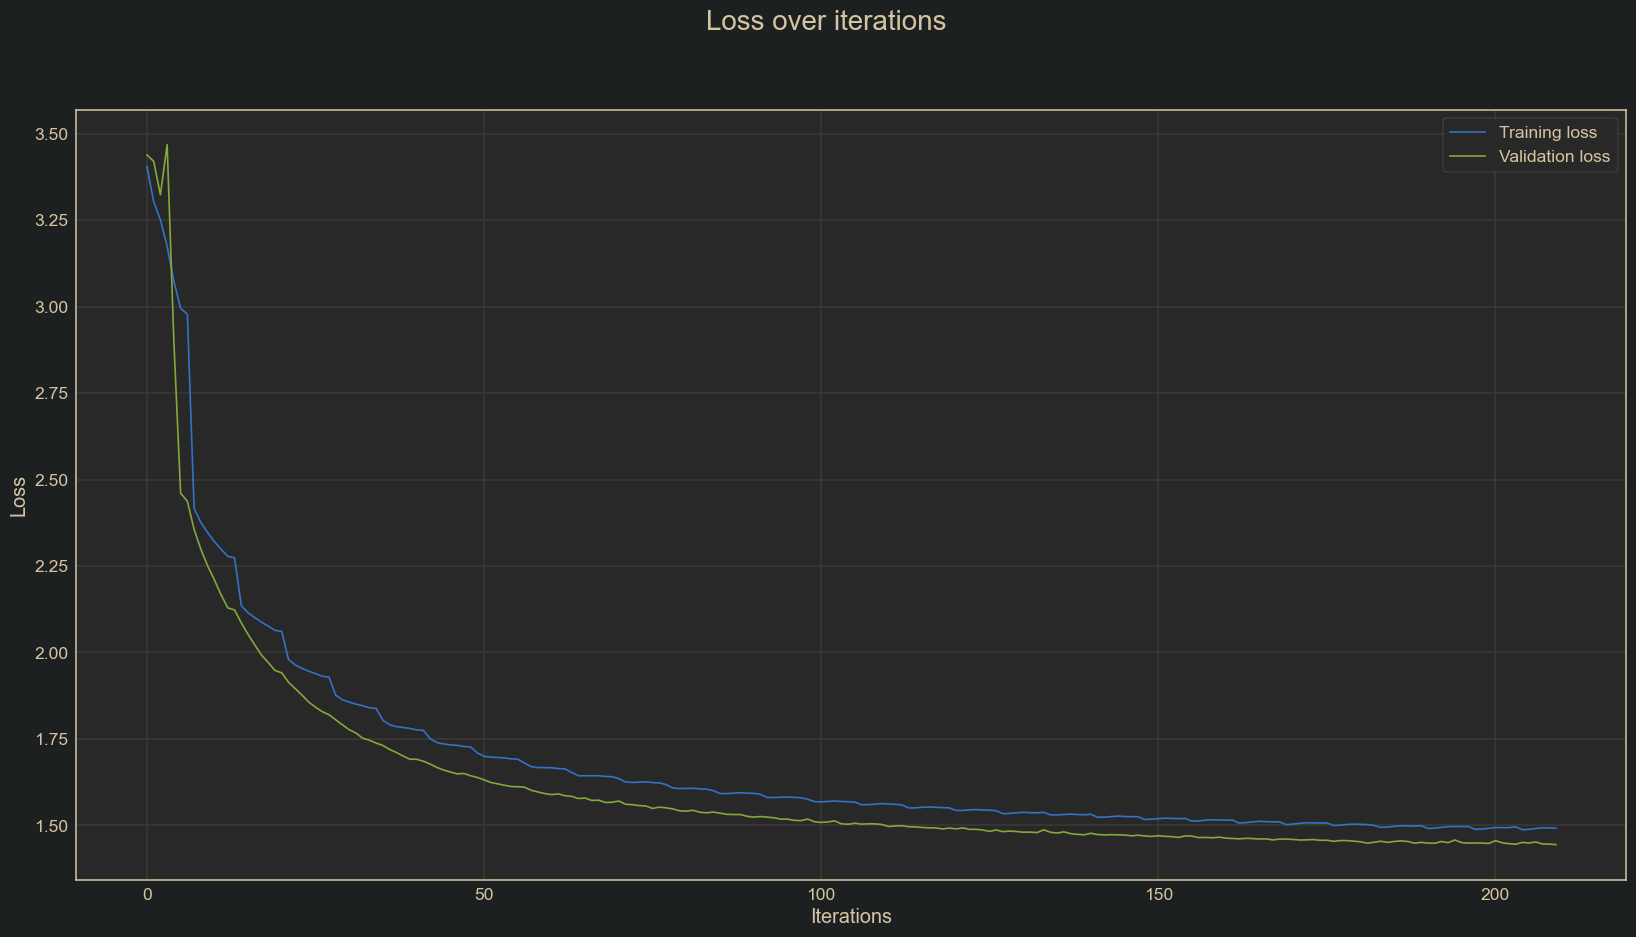

In [48]:
plt.figure(figsize = (20, 10))
plt.plot(range(len(running_train_loss)), running_train_loss, label = "Training loss")
plt.plot(range(len(running_val_loss)), running_val_loss, label = "Validation loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.suptitle("Loss over iterations", fontsize = 20)
plt.legend()
plt.show(); plt.close("all")

In [49]:
### Freeze model weights
model.requires_grad_ = False

In [50]:
int2char = encoding_results.int2char
char2int = encoding_results.char2int

In [51]:
seed = "Lan al'Mandragoran went up the mountain"
k = 5

In [52]:
def predict(x, h, net, k = 5):
    x = np.array([[char2int[x]]])
    x = one_hot_encode(x, len(unique_chars))
    x = torch.from_numpy(x).to(device).contiguous()
    
    out, h = net(x, h)
    p = F.softmax(out, dim = -1).data
    p, chars = p.topk(k, dim=-1)
    
    chars = chars.detach().cpu().numpy().squeeze()
    p = p.detach().cpu().numpy().squeeze()
    
    return np.random.choice(chars, p = p/p.sum()), h

In [53]:
h = torch.distributions.Normal(scale = 0.5, loc = 0.).sample((num_layers, 1, hidden_size)).zero_().to(device)
predict("D", h, model, 5)

(61,
 tensor([[[-0.3820, -0.0433, -0.4190,  ...,  0.4913,  0.2049, -0.3379]],
 
         [[-0.8417, -0.6133, -0.9985,  ..., -0.9338,  0.9912, -0.9806]]],
        device='cuda:0', grad_fn=<CudnnRnnBackward0>))

In [54]:
seed_list = list(seed)

h = torch.distributions.Normal(scale = 0.5, loc = 0.).sample((num_layers, 1, hidden_size)).zero_().to(device)

for char in seed_list:
    h = h.data
    next_char, h = predict(char, h, model, k)

seed_list.append(int2char[next_char])
seed_list_1 = seed_list.copy()
seed_list_2 = seed_list.copy()

In [55]:
print(''.join(seed_list))

Lan al'Mandragoran went up the mountaine


In [56]:
## Method 1
for ii in range(1000):
    h = h.data
    next_char, h = predict(seed_list_1[-1], h, model, k)
    seed_list_1.append(int2char[next_char])

In [57]:
## Method 2
for ix in range(1000):
    h = h.data
    x = np.array(char2int[seed_list_2[-1]]).reshape(1, -1)
    x = one_hot_encode(x, len(unique_char))
    x = torch.tensor(x).to(device)
    out, h = model(x, h)
    
    p = F.softmax(out, dim=-1)
    p, chars = p.topk(k = k, dim=-1)
    chars = chars.detach().cpu().numpy().squeeze()
    p = p.detach().cpu().numpy().squeeze()
    seed_list_2.append(int2char[np.random.choice(chars, p = p/p.sum())])
    #next_char = chars[torch.distributions.Uniform(low = 0, high = k).sample().to(torch.int32).item()].item()
    #seed_list.append(int2char[next_char])
    

In [58]:
pred_text = ''.join(seed_list_1)

In [59]:
print(pred_text)

Lan al'Mandragoran went up the mountained horred and
conversaty on the bore for him,
and the poad and her faneral, with to her hias of the sensing from the bairily would have no inen the paring, and to difiid as he had been done in, and the strong and straight of
thoughist him and the
sintly, and so stray had happened that her
and showt on the tore out of the bedsion. His fingers, sent to the pood tines of the dirnce tare of the bedry of the siges in sick mone of the best one and some himself on his son, and the door.

"I'm always do you have a self--they wanted time to soye if it had not been
came in the couthel has bied in his
eyes." 
Alexey Alexandrovitch, whan at this and the prove to her, and thinking our, and she winhed."

"Yes? You around my fore and some from a
life werl her has a that was a while in her for she would not be the
sound of
happy of the same dissation about him. "What is that her treet, but that distined," said Kitty, and with whom has his serreaty; he felt some t

In [60]:
pred_text = ''.join(seed_list_2)

In [61]:
print(pred_text)

Lan al'Mandragoran went up the mountaine children's feeling over the
possting the chied, but the paiting for her...

"No, they had to
be told her hand.

"What with a carriage,"
has had
a teres and have time to a geeting how,, and I have the bridlisal, the
stard, but that he conersting out or the room of the belity ow him. He told her. "Why do you and she talking, as a
potite fire it as all there is to all the moment of the
child explint at the son the stritgle was a moment to him, and he was the consequence. She was
so
as the marshal and the paintanter the minute. There is she was the contrary of the balles. The carding her, and had bound in thes of the prince she
was so as all the moment with the sone to be so thit in them."

"Werr," said Alexey Alexandrovitch, and had ten to them were ill awsited the bightly and the chood anster on the thought. He thiskent with his sigh and his face,
the pate, and sein his what of the pracal intones in his friend, and his head, send and dident in her